TiffPage 0: TypeError: read_bytes() missing 3 required positional arguments: 'dtype', 'count', and 'offsetsize'


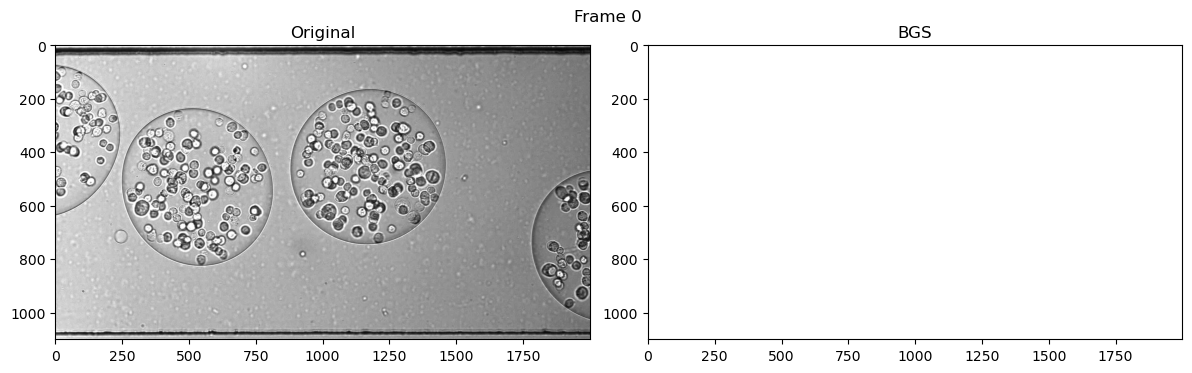

In [3]:
import cv2
import numpy as np
import tifffile as tiff
import os
import matplotlib.pyplot as plt
import matplotlib.animation as mat_anim
from IPython.display import HTML

# Function to present the Original and BGS frames side by side for visualisation.
def draw_frames(frames, bgs_frames):
    if len(frames) != len(bgs_frames):
        raise Exception("The number of frames on each array doesn't match.")
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    plt.tight_layout()

    def update(frame):
        plt.suptitle(f"Frame {frame}")
        axs[0].clear()
        axs[1].clear()
        axs[0].set_title("Original")
        axs[0].imshow(frames[frame], cmap='gray')
        axs[1].set_title("BGS")
        axs[1].imshow(bgs_frames[frame], cmap='gray')
        return axs

    return mat_anim.FuncAnimation(fig=fig, func=update, frames=len(frames), interval=500)

def convert_to_grayscale(rgb_image):
    return np.dot(rgb_image[..., :3], [0.2989, 0.5870, 0.1140])

def process_TIF(filepath):
    array = tiff.imread(filepath)
    gray_arr = convert_to_grayscale(array)
    return gray_arr

def picture_frames(frame_list, frame_index):
    num_frames = len(frame_list)
    fig, axs = plt.subplots(1, num_frames, figsize=(4 * num_frames, 4))
    plt.tight_layout()

    for i in range(num_frames):
        ax = axs[i]
        frame = frame_list[i]
        frame_name = frame_index[i]
        title = f"Frame {frame_name}"
        ax.imshow(frame, cmap='gray')
        ax.set_title(title)
        ax.axis('off')  # Hide the axis

    plt.show()

def crop_frame(frame, target_height):
    return frame[:target_height, :]

def background_subtraction_cv2(frames, history=500, varThreshold=16, detectShadows=True):
    subtractor = cv2.createBackgroundSubtractorMOG2(history=history, varThreshold=varThreshold, detectShadows=detectShadows)

    num_frames, width, height = frames.shape
    grayscale_masks = np.zeros((num_frames, width, height), dtype=np.uint8)

    for frame_num in range(num_frames):
        current_frame = frames[frame_num]

        mask = subtractor.apply(current_frame)

        grayscale_masks[frame_num] = cv2.bitwise_not(mask)

    return grayscale_masks

# Load data
seq41 = process_TIF("../Data/All_Sequences/4-1.tif")
seq41 = seq41[:20]

# Create or load the background image
input_folder = "../Data/All Sequences"
output_file = "background_init.tif"

# Perform background subtraction using cv2 method
bgs41_cv2 = background_subtraction_cv2(seq41)

# Display the original side by side with the foreground masks as a video
animation = draw_frames(seq41[:20], bgs41_cv2)
HTML(animation.to_html5_video())

